In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from numpy import sin, cos, pi, arctan2, sqrt
from heapq import heappush, heappop
#from sklearn.cluster import KMeans
from sys import stdout
import json
from copy import deepcopy
import os
import shapefile as shp
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import random
import matplotlib.colors as colors
import matplotlib.cm as cmx
import csv as csv

%matplotlib inline

In [2]:
os.getcwd()
inputDir = './InputData/'

In [3]:
data_single = np.genfromtxt(inputDir+'SingleParcelConsumption.csv', delimiter=',', skip_header=1, dtype=None)
# get the monthly average consumption
# acct ids have already been randomised
data_mat = [[x for x in data_single[y]] for y in np.arange(np.shape(data_single)[0])]
# the buildings coordinates are taken as the parcel Centroids
buildings = [x[2:4] for x in data_mat]
mgNumber = [x[1] for x in data_mat]
use = [x[0] for x in data_mat]
acctId = [x[4] for x in data_mat]

#The names of the pair of text files containing the road nodes and edges respectively
road_nodes, road_edges = 'Cambridge_Street_Nodes.txt', 'Cambridge_Street_Edges.txt'
#The n_clusters parameter for sklearn's k-means clustering function (determines the number of clusters used)
nClusters = 100    
#Resolution of the segmented road network that's used when connecting electrical loads (in km)
resolution = 0.001 
#The minimum allowed gap size (in km) in the microgrid, any smaller gaps will be filled in to improve connectivity 
minimumGap = 0.05
#The distance that will be used when connecting electrical loads to the roads ("spatial" will calculate the distance in km, otherwise it expects a number)
defaultDistance = 'spatial'

In [4]:
print len(set(acctId))

4574


In [5]:
def readRoad(filePath):
    """Imports the intersections (nodes) and roads (edges) of the road network"""
    with open(filePath+road_nodes, 'r') as f:
        rows = f.read().splitlines()
        size = len(rows)
        inter = [0]*(size-1)
        index = {}
        for i in range(1,size):
            row = rows[i].split()
            inter[i-1] = [int(row[0]), float(row[1]), float(row[2])]
            index[int(row[0])] =  ( row[1], row[2] )
    with open(filePath+road_edges, 'r') as f:
        rows = f.read().splitlines()
        size = len(rows)
        roads = [0]*(size-1)
        for i in range(1,size):
            row = rows[i].split()
            roads [i-1] = [ row[0], index[int(row[1])], index[int(row[2])] ]
    return inter, roads

def distance(A,B):
    """Calculates the distance (in km) between two lat/long pairs (in degrees, WGS84 projection)"""
    a = sin( (A[1]-B[1])*pi/360. )**2 + cos(A[1]*pi/180.)*cos(B[1]*pi/180.)*(sin((A[0]-B[0])*pi/360.)**2)
    return 6371.*2*arctan2(sqrt(a), sqrt(1-a))

def segment_roads(graph, edge, size):
    A, B = (float(edge[0][0]), float(edge[0][1])), (float(edge[1][0]), float(edge[1][1]))
    dist = distance(A,B)
    if dist <= size: segments = 1
    else: 
        segments = int(dist/size)
        if ((dist/size) - segments) > 0.5: segments += 1
    dx,dy = (B[0]-A[0])/segments, (B[1]-A[1])/segments
    graph.add_node( edge[0], pos = A, layer = 'road' )
    nodes = [ edge[0] ]
    for i in range(1,segments):
        nodes.append( (A[0]+i*dx,A[1]+i*dy) )
        graph.add_node( nodes[-1], pos = ( A[0]+i*dx, A[1]+i*dy), layer = 'road')
        graph.add_edge( nodes[-2], nodes[-1], dist = distance(graph.node[nodes[-2]]['pos'],graph.node[nodes[-1]]['pos']), layer = 'road' )
    graph.add_node( edge[1], pos = B, layer = 'road')
    graph.add_edge( nodes[-1], edge[1], dist = distance(graph.node[nodes[-1]]['pos'],graph.node[edge[1]]['pos']), layer = 'road' )
    
    
def createRoadNetwork(fPath, size = 10./110000.):
    graph = nx.Graph()
    nodes, edges = readRoad(fPath)
    graph1 = nx.Graph()
    for n in nodes: graph1.add_node( (n[1],n[2]) )
    for i, e1, e2 in edges: graph1.add_edge( (float(e1[0]),float(e1[1])), (float(e2[0]),float(e2[1])) )
    graphs = list( nx.connected_component_subgraphs(graph1) )
    graphs.sort(key = len)
    nodes, edges = graphs[-1].nodes(), graphs[-1].edges()
    for e1, e2 in edges:
        segment_roads(graph, (e1, e2), size)
    graph2 = nx.Graph()
    index = {}
    nodeCounter = 0
    for n in graph.node:
        index[n] = 'r' + str(nodeCounter)
        graph2.add_node( index[n], layer = 'road' )
        for attr in graph.node[n]: graph2.node[index[n]][attr] = graph.node[n][attr]
        nodeCounter += 1
    for e1, e2 in graph.edges():
        graph2.add_edge( index[e1], index[e2], layer = 'road')
        for attr in graph.edge[e1][e2]: graph2.edge[index[e1]][index[e2]][attr] = graph.edge[e1][e2][attr]
    return graph2


def nearestIntersection(graph,start):
    closest = (1000, None)
    for n in graph.node:
        if graph.node[n]['layer'] == 'road':
            dist = distance(start, graph.node[n]['pos']) #np.sqrt( (start[0]-graph.node[n]['pos'][0])**2 + (start[1]-graph.node[n]['pos'][1])**2 )
            if dist < closest[0]: 
                closest = (dist, n)
    return closest[1]

def nearestIntersection2(graph, coords, N = 50):
    coordinates = [ (graph.node[n]['pos'][0], graph.node[n]['pos'][1], n) for n in graph.node ]
    xmin, xmax, ymin, ymax = min(coordinates)[0], max(coordinates)[0], min(coordinates, key = lambda t: t[1])[1], max(coordinates, key = lambda t: t[1])[1]
    dx, dy = (xmax-xmin)/N, (ymax-ymin)/N
    grid = [ [ [] for n in range(N+1) ] for m in range(N+1) ]
    for c in coordinates: grid[int((c[0]-xmin)/dx)][int((c[1]-ymin)/dy)].append(c[2])
    result = {}
    for index in range(len(coords)):
        x, y = coords[index]
        i, j = int((x-xmin)/dx), int((y-ymin)/dy)
        cells = { (i+di, j+dj) for di in range(-1,2) if 0 <= i+di < len(grid) for dj in range(-1,2) if 0 <= j+dj < len(grid[0]) }
        nodes = []
        for c in cells: 
            if 0 <= c[0] < len(grid) and 0 <= c[1] < len(grid[0]): nodes += grid[c[0]][c[1]]
        closest = (1000, None)
        for n in nodes:
            if graph.node[n]['layer'] == 'road':
                dist = np.sqrt( (x-graph.node[n]['pos'][0])**2 + (y-graph.node[n]['pos'][1])**2 )
                if dist < closest[0]: 
                    closest = (dist, n)
        result[index] = closest[1] 
    return result

def nearestIntersection3(graph, clusters, coords, N = 50):
    coordinates = [ (graph.node[n]['pos'][0], graph.node[n]['pos'][1], n) for n in graph.node ]
    xmin, xmax, ymin, ymax = min(coordinates)[0], max(coordinates)[0], min(coordinates, key = lambda t: t[1])[1], max(coordinates, key = lambda t: t[1])[1]
    dx, dy = (xmax-xmin)/N, (ymax-ymin)/N
    grid = [ [ [] for n in range(N+1) ] for m in range(N+1) ]
    for c in coordinates: grid[int((c[0]-xmin)/dx)][int((c[1]-ymin)/dy)].append(c[2])
    result = {}
    for m in clusters:
        x, y = coords[clusters[m]]
        i, j = int((x-xmin)/dx), int((y-ymin)/dy)
        cells = { (i+di, j+dj) for di in range(-1,2) if 0 <= i+di < len(grid) for dj in range(-1,2) if 0 <= j+dj < len(grid[0]) }
        nodes = []
        for c in cells: 
            if 0 <= c[0] < len(grid) and 0 <= c[1] < len(grid[0]): nodes += grid[c[0]][c[1]]
        closest = (1000, None)
        for n in nodes:
            if graph.node[n]['layer'] == 'road':
                dist = np.sqrt( (x-graph.node[n]['pos'][0])**2 + (y-graph.node[n]['pos'][1])**2 )
                if dist < closest[0]: 
                    closest = (dist, n)
        result[m] = closest[1]
    return result


### Network-based cluster growth method ###

def cluster_centroids(clusters, coords):
    clusterDict = {}
    centroid = {}
    for i, c in enumerate(clusters):
        if c not in clusterDict: clusterDict[c] = []
        clusterDict[c].append( i )
    for c, indices in clusterDict.items():
        x, y = sum([coords[i][0] for i in indices])/len(indices), sum([coords[i][1] for i in indices])/len(indices)
        closest = (1000, None)
        for i in indices:
            dist = np.sqrt( (x-coords[i][0])**2 + (y-coords[i][1])**2 )
            if dist < closest[0]: closest = (dist, i)
        centroid[c] = closest[1]
    return centroid

def cluster_growth(graph, starts, destinations, weight = 'dist', scale = 3.):
    dest = { d for d in destinations }
    seen, roots = {}, {}
    q = [ (0., start, None, start, 0.) for start in starts ]
    while q:
        dist, current, parent, root, prev = heappop(q)
        if current in seen: continue
        seen[current] = parent
        if current in dest:
            roots[current] = root
            dest.remove(current)
            if len(dest) == 0:
                return seen, roots
        for nextNode in graph.edge[current]:
            if nextNode not in seen:
                heappush( q, (dist + graph.edge[current][nextNode][weight], nextNode, current, root, graph.edge[current][nextNode][weight]) )
    return seen, roots

def cluster_gaps(graph, roads, limit = 0.035, weight = 'dist'):
    gaps = set()
    for node in graph.node:
        dest = { d for d in graph.node if d != node}
        seen = {}
        q = [ (0., node, None) ]
        while q:
            dist, current, parent = heappop(q)
            if dist > limit: break
            if current in seen: continue
            seen[current] = parent
            if current in dest and current != node:
                n = current
                while seen[n] is not None:
                    gaps.add( (seen[n], n) )
                    n = seen[n]
                dest.remove(current)
                if len(dest) == 0:
                    break
            for nextNode in roads.edge[current]:
                if nextNode not in seen:
                    heappush( q, (dist + roads.edge[current][nextNode][weight], nextNode, current) )
    return gaps



### Functions to reduce unnecessary road nodes from the graph ###

def route_length(graph, route, weight):
    length = 0.
    for e1, e2 in route:
        length += graph.edge[e1][e2][weight]
    return length


def reduce_graph(graph0, keep, weight = 'dist'):
    graph = graph0.copy()
    for node in graph.nodes():
        if node not in keep and len(graph.edge[node]) == 2:
            edges = graph.edge[node].keys()
            graph.add_edge(edges[0], edges[1], { weight: graph.edge[node][edges[0]][weight] + graph.edge[node][edges[1]][weight], 'layer': 'road'} )
            graph.remove_node(node)
    return graph

def read_graph(filePath):
    with open(filePath, 'r') as f:
        data = [ json.loads(row) for row in f.read().splitlines() ]
    graphs = []
    for d in data:
        if d["type"] == "DiGraph": graph = nx.DiGraph()
        elif d["type"] == "Graph": graph = nx.Graph()
        else:
            print "Not a valid graph"
            return
        for n, attr in d['nodes'].items(): graph.add_node(n, attr)
        for n1, edges in d['edges'].items():
            for n2, attr in edges.items(): graph.add_edge(n1, n2, attr)
        graphs.append(graph)
    return graphs

def write_graph(graphs, filePath):
    with open(filePath, "w+") as f:
        for i, graph in enumerate(graphs):
            if type(graph) == nx.DiGraph: data = {"type": "DiGraph" }
            elif type(graph) == nx.Graph: data = {"type": "Graph" }
            else:
                print "Not a valid graph"
                return
            data['nodes'], data['edges'] = graph.node, graph.edge
            if i > 0: f.write( "\n" )
            f.write( json.dumps(data) )

In [6]:
def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""

In [7]:
print "Getting Building Locations"
stdout.flush()

coords = np.copy( buildings )

print "\n" + str(len(coords)), "buildings found"
    
stdout.flush()

# the k means clustering has already been done and the coordinates have an assigned microgrid number

clusters = []    
for x in mgNumber:
    clusters.append( x )
MG_clusters = np.asarray( clusters[0:] )

Getting Building Locations

4574 buildings found


In [8]:
singleHomes = np.arange(len(clusters))

kcluster=200
numUsers = np.zeros((kcluster))
for clstr in range(kcluster):
    clusterHomes = [singleHomes[a] for a, b in enumerate(clusters) if b==clstr]
    numUsers[clstr] = len(clusterHomes)

In [9]:

print "Creating initial network"
stdout.flush()
road = createRoadNetwork(inputDir, resolution)
print "\tNumber of nodes:", len(road.node), "\n\tAdding houses and simplifying network"
stdout.flush()
nodeCounter = 0
allNodes = nearestIntersection2(road, coords, 50)
for i in range(len(clusters)):
    if i not in allNodes or allNodes[i] == None : 
        print i
        allNodes[i] = nearestIntersection(road, coords[i])
stdout.flush()
road = reduce_graph(road, set(allNodes.values()))

Creating initial network
	Number of nodes: 241778 
	Adding houses and simplifying network


In [10]:
print "Generating new clusters"
stdout.flush()
centroids = cluster_centroids(clusters, coords) 
nearest = nearestIntersection3(road, centroids, coords)
seen, roots = cluster_growth(road, nearest.values(), allNodes.values() )

clusters =  {}
for n in roots:
    if roots[n] not in clusters: clusters[roots[n]] = set()
    prev, current = n, seen[n]
    while current != None:
        clusters[roots[n]].add( (current, prev) )
        prev, current = current, seen[current]

Generating new clusters


In [11]:
# understand these new clusters...
print clusters[clusters.keys()[0]]

set([('r105713', 'r222526'), ('r211092', 'r222196'), ('r69619', 'r240597'), ('r123933', 'r28183'), ('r92420', 'r102667'), ('r179618', 'r41664'), ('r28183', 'r109845'), ('r123940', 'r179618'), ('r222196', 'r180446'), ('r88914', 'r71597'), ('r34206', 'r105713'), ('r28183', 'r92420'), ('r88914', 'r211092'), ('r109845', 'r217165'), ('r71597', 'r34206'), ('r222526', 'r139977'), ('r105713', 'r60824'), ('r116422', 'r206322'), ('r107691', 'r69619'), ('r206322', 'r107691'), ('r34206', 'r123933'), ('r180446', 'r116422'), ('r102667', 'r84825'), ('r60824', 'r123940')])


In [12]:
graphs = [] 
addedNodes = set()
for i, c in enumerate(clusters):
    graphs.append( nx.Graph() )
    for e1, e2 in clusters[c]:
        addedNodes.update( [e1,e2] )
        graphs[-1].add_node(e1, road.node[e1], cluster = i, root = c, layer = 'road')
        graphs[-1].add_node(e2, road.node[e2], cluster = i, root = c, layer = 'road')
        #attr = road.edge[e1][e2]
        #attr['cluster'], attr['root'] = i, c
        graphs[-1].add_edge(e1, e2, road.edge[e1][e2], cluster = i, root = c, layer = 'road')

In [13]:
if minimumGap is not None and minimumGap > 0:
    print "Filling in any gaps smaller than", 1000*minimumGap, "meters" 
    for graph in graphs:
        gaps = cluster_gaps(graph, road, minimumGap)
        for e1, e2 in gaps:
            if e1 in addedNodes or e2 in addedNodes: continue
            addedNodes.update( [e1,e2] )
            if e1 not in graph.node: graph.add_node(e1, road.node[e1], cluster = i, root = c, layer = 'road')
            if e2 not in graph.node: graph.add_node(e2, road.node[e2], cluster = i, root = c, layer = 'road')
            #attr = road.edge[e1][e2]
            #attr['cluster'], attr['root'] = i, c
            graph.add_edge(e1, e2, road.edge[e1][e2], cluster = i, root = c, layer = 'road')

Filling in any gaps smaller than 50.0 meters


In [14]:
allNodes2 = {}
for i, node in allNodes.items():
    if node not in allNodes2: allNodes2[node] = []
    allNodes2[node].append(i)
for graph in graphs:
    for n in graph.nodes():
        if n not in allNodes2: continue
        for i in allNodes2[n]: 
            graph.add_node(i, deepcopy(graph.node[n]), layer = 'building')
            graph.node[i]['pos'] = coords[i]
            graph.add_edge(i, n, cluster=graph.node[n]['cluster'], root=graph.node[n]['root'], layer = 'building' )
            graph.edge[i][n]['dist'] = distance( coords[i], graph.node[n]['pos'] ) if defaultDistance == "spatial" else defaultDistance


/usr/local/lib/python2.7/dist-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/usr/local/lib/python2.7/dist-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:


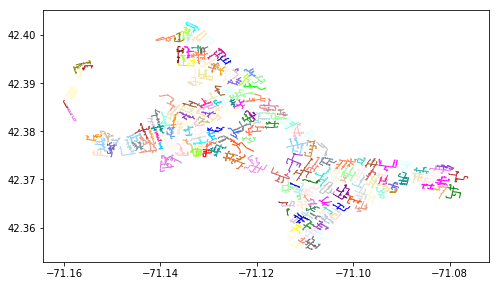

In [15]:
fig1 = plt.figure(1)
fig1.set_size_inches(8, 5)
ax = fig1.add_subplot(111)
colors = [ 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue', 'cornsilk', 'crimson', 'cyan', 'darkcyan', 'darkgoldenrod', 'darkkhaki', 'darkmagenta', 'darkorange', 'darkorchid', 'darkred', 'darksalmon', 'darkturquoise', 'deeppink', 'deepskyblue', 'dimgray', 'dodgerblue', 'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro', 'gold', 'goldenrod', 'gray', 'green', 'greenyellow', 'hotpink', 'indianred', 'khaki', 'lavender', 'lavenderblush', 'lawngreen', 'lemonchiffon', 'lightblue', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgreen', 'lightgray', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue', 'lightslategray', 'lightsteelblue', 'lightyellow', 'lime', 'limegreen', 'linen', 'magenta', 'maroon', 'mediumaquamarine', 'mediumblue', 'mediumorchid', 'mediumpurple', 'mediumseagreen', 'mediumslateblue', 'mediumspringgreen', 'mediumturquoise', 'mediumvioletred', 'mistyrose', 'moccasin', 'navajowhite', 'oldlace', 'olive', 'olivedrab', 'orange', 'orangered', 'orchid', 'palegoldenrod', 'palegreen', 'paleturquoise', 'palevioletred', 'papayawhip', 'peachpuff', 'peru', 'pink', 'plum', 'powderblue', 'purple', 'red', 'rosybrown', 'royalblue', 'saddlebrown', 'salmon', 'sandybrown', 'seagreen', 'seashell', 'sienna', 'silver', 'skyblue', 'slateblue', 'slategray', 'springgreen', 'steelblue', 'tan', 'teal', 'thistle', 'tomato', 'turquoise', 'violet', 'wheat', 'yellow', 'yellowgreen' ]
for graph in graphs:
    pos = { n: graph.node[n]['pos'] for n in graph.node }
    color = colors[np.random.randint(len(colors))]
    nx.draw_networkx_edges(graph, pos, alpha=1.0, edge_color=color, width=1)
ax.set_aspect(1)
ax.get_xaxis().get_major_formatter().set_scientific(False)

In [16]:
# get a list of the new coords and MG number
MGNumber = []
coords = []
useNew = []
idxNew = []
for i, graph in enumerate(graphs):
    for key in graph.node:
        if graph.node[key]['layer'] == 'building':
            coords.append( graph.node[key]['pos'] )
            #useNew.append( use[np.where(buildings==graph.node[key]['pos'])[0][0]] )
            #idxNew.append( acctId[np.where(buildings==graph.node[key]['pos'])[0][0]] )
            MGNumber.append( i )
            
    
print len(coords)

4574


In [17]:
print len(coords)
newNumUsers = [sum(1 for no in MGNumber if no==i) for i in range(200)]
print newNumUsers

4574
[20, 10, 26, 28, 19, 27, 29, 29, 28, 20, 24, 30, 38, 24, 34, 32, 18, 13, 17, 24, 30, 27, 18, 19, 13, 7, 18, 54, 18, 37, 19, 13, 14, 14, 16, 24, 18, 11, 22, 22, 16, 29, 18, 19, 5, 34, 15, 29, 15, 30, 34, 25, 35, 38, 12, 35, 27, 19, 26, 43, 34, 26, 24, 54, 21, 5, 10, 25, 29, 14, 29, 28, 19, 37, 19, 14, 26, 32, 28, 10, 26, 11, 12, 13, 16, 40, 19, 13, 7, 11, 29, 42, 27, 21, 9, 31, 27, 54, 12, 24, 30, 18, 16, 21, 24, 10, 16, 22, 18, 37, 23, 22, 12, 14, 41, 40, 26, 45, 18, 19, 18, 21, 17, 14, 20, 20, 38, 23, 22, 40, 18, 20, 15, 26, 30, 23, 29, 15, 17, 22, 30, 33, 17, 10, 22, 28, 27, 15, 10, 14, 18, 15, 15, 21, 26, 18, 10, 12, 18, 30, 6, 36, 38, 4, 19, 21, 17, 50, 16, 22, 16, 18, 18, 18, 19, 14, 34, 28, 13, 21, 12, 6, 46, 16, 18, 17, 21, 51, 17, 31, 42, 22, 26, 20, 30, 37, 23, 18, 14, 34]


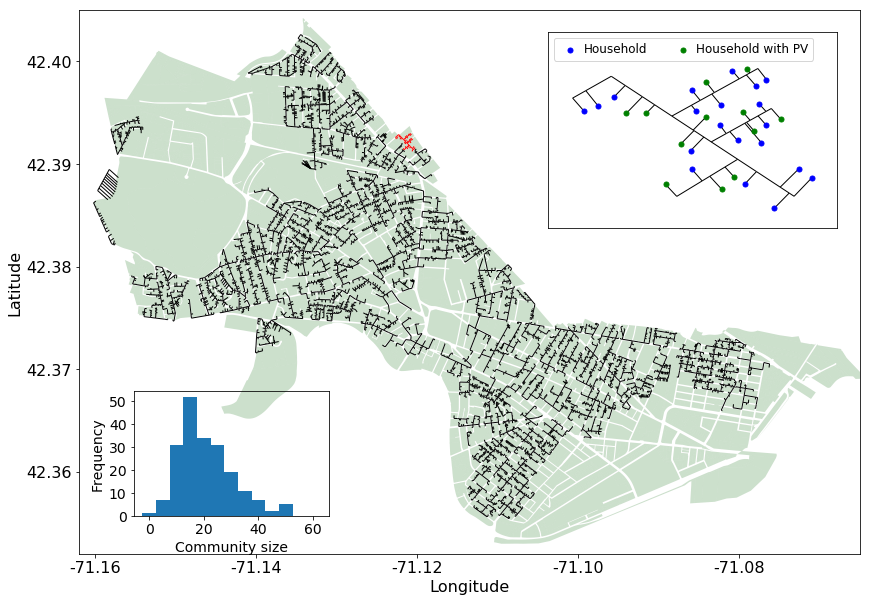

In [19]:
fs = 14
filePath = inputDir+'CambParcelsLatLong.shp'
sf = shp.Reader(filePath)
recs = sf.records()
fields = sf.fields
shapes = sf.shapes()
ptchs=[]

fig1 = plt.figure(1)
fig1.set_size_inches(14,10)
ax1 = fig1.add_subplot(111)
for areas in shapes:
    x=[area[0] for area in areas.points]
    y=[area[1] for area in areas.points]
    #ax.plot(x,y,color='k')
    pols = zip(x,y)
    poly = Polygon(pols)
    ptchs.append(poly)
ax1.add_collection(PatchCollection(ptchs,facecolor='darkgreen', alpha=0.2, edgecolor='none'))
plt.sca(ax1)
for i, graph in enumerate(graphs):
    # draw the edges on the graph
    parcCoordDict = {key: graph.node[key]['pos'] for key in graph.node}
    if i == 77:
        D1 = nx.draw_networkx_edges(graph, parcCoordDict, edge_color='red')
    else:
        D1 = nx.draw_networkx_edges(graph, parcCoordDict)

ax1.set_xlim([-71.162, -71.065])
ax1.set_ylim([42.352, 42.405])
ax1.set_xticks(np.arange(-71.16,-71.07,0.02))
tickX = []
for entry in np.arange(-71.16,-71.07,0.02):
    tickX.append( '%.2f'%entry )
ax1.set_xticklabels(tickX)
ax1.set_yticks(np.arange(42.36,42.41,0.01))
tickY = []
for entry in np.arange(42.36,42.41,0.01):
    tickY.append( '%.2f'%entry )
ax1.set_yticklabels(tickY)
ax1.tick_params(axis='both', which='major', labelsize=fs+2)
ax1.set_xlabel('Longitude', fontsize=fs+2)
ax1.set_ylabel('Latitude', fontsize=fs+2)

pos = ax1.get_position()
a = plt.axes([pos.x0 + 0.07*pos.width, pos.y0 + 0.07*pos.height,  pos.width*0.25, pos.height*0.23])
# create a histogram of the microgrid sizes
bW = 5
nUBins = np.arange(0,70,bW)
nUHist, nUEdges = np.histogram(newNumUsers, nUBins, density=False)
a.bar(nUBins[:-1], nUHist, width=bW)
a.set_xticks(np.arange(0,65,20))
a.set_yticks(np.arange(0,51,10))
a.set_xlabel('Community size', fontsize=fs)
a.set_ylabel('Frequency', fontsize=fs)
a.tick_params(axis='both', which='major', labelsize=fs)
a.patch.set_facecolor('w')
a.patch.set_alpha(0)

b = plt.axes([pos.x0 + 0.6*pos.width, pos.y0 + 0.6*pos.height,  pos.width*0.37, pos.height*0.36])
parcCoordDict = {key: graphs[77].node[key]['pos'] for key in graphs[77].node}
nx.draw_networkx_edges(graphs[77], parcCoordDict)
pointsHouseholds = []
for key in graphs[77].node:
    if graphs[77].node[key]['layer'] == 'building':
        pointsHouseholds.append( graphs[77].node[key]['pos'] )
for i, p in enumerate(pointsHouseholds):

    # simulate the solar nodes choices
    r1 = random.uniform(0.0, 1.0)
    if r1<0.4:
        gN = plt.scatter(p[0], p[1], marker='o', s=25, color='green')
    else:
        lN = plt.scatter(p[0], p[1], marker='o', s=25, color='blue')
b.set_xticks([])
b.set_yticks([])
b.set_ylim([42.391, 42.39342])
b.legend((lN, gN), ('Household', 'Household with PV'), scatterpoints=1, loc='upper left', ncol=3, \
         fontsize=12, handletextpad = 0.1)
#fig1.savefig('Images/RoadNetworkCommunities.png', dpi=300,bbox_inches = 'tight',format='png')

In [20]:
#### Now write to a csv file
with open('./IntermediateData/SingleHomesConsumption.csv', 'wb') as OutFile:
    mywriter = csv.writer(OutFile, delimiter=',')
    RowData = ['Use', 'MGNum', 'Long', 'Lat', 'Acct id']
    mywriter.writerow(RowData) 
    #### write id and consumption
    for i in range(len(coords)):
        RowData = np.zeros((1,5))
        RowData[0, 0] = use[i]
        RowData[0, 1] = MGNumber[i]
        RowData[0, 2] = coords[i][0]
        RowData[0, 3] = coords[i][1]
        RowData[0, 4] = acctId[i]

        mywriter.writerow(RowData[0,:])    